In [1]:
import keras
import tensorflow as tf

config = tf.ConfigProto( device_count = {'GPU': 1} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

Using TensorFlow backend.


# Simple Captions
The first step is to prepare the data.

In [2]:
import json

with open('data/data.json') as infile:  
    data = json.load(infile)

In [3]:
len(data['moves'])

78869

I needed a function to translate from algebraic notation to a sentence.

In [12]:
def pieceToWord(notation, verbose=False):
    '''
    Returns a short sentence describing a piece and its position
    '''
    
    pieces = {
        "B": "Bishop",
        "R": "Rook",
        "K": "King",
        "Q": "Queen",
        "N": "Knight"
    }
    
    length = len(notation)
    
    if length == 0:
        return "Pawn"
    
    if length == 1:
        if notation.islower(): # Pawn
            if verbose:
                return "Pawn from file " + notation
            else:
                return "Pawn"
        else: # Higher piece
            return pieces[notation]
    
    piece = pieces[notation[0]]
    
    if not verbose:
        return piece
    
    if length == 2:
        if notation[1].isdigit(): # rank
            return piece + " from rank " + notation[1]
        else: # file
            return piece + " from file " + notation[1]
    
    if length == 3: # rank and file
        return piece + " from square " + notation[1:] 

def moveToSentence(move, verbose=False):
    '''
    Translates a move in the algebraic notation into a caption.
    '''
    
    pieces = {
        "B": "Bishop",
        "R": "Rook",
        "K": "King",
        "Q": "Queen",
        "N": "Knight"
    }
    
    action = " to " # Default action is move
    modifier = "" # Default no modifier
    
    if "+" in move: # Check
        if verbose:
            modifier = " with check"
        move = move[:-1]
    
    if "#" in move: # Checkmate
        if verbose:
            modifier = " with checkmate"
        move = move[:-1]
        
    if "=" in move: # Pawn promotion
        if verbose:
            modifier = " with promotion to " + pieces[move[-1:]].lower() + modifier
        move = move[:-2]
        
    if "e.p." in move: # En passant
        move = move.replace('e.p.', '')
        if verbose:
            return  " en passant" + modifier
    
    # Special cases
    if "O-O" == move: # Kingside caste
        return "Kingside castle" + modifier
    
    if move == "O-O-O": # Queenside castle
        return "Queenside castle" + modifier    
        
    # extract final position
    position = move[-2:]
    move = move[:-2]
        
    if "x" in move: # Capture
        action = " takes on "
        move = move[:-1]
        
    piece = pieceToWord(move, verbose)
    
    return piece + action + position + modifier + " <End>"

moveToSentence("dxe8=Q+", True)

'Pawn from file d takes on e8 with promotion to queen with check <End>'

In [5]:
# Helper methods to convert fens to the matrix representation
import numpy as np

def indexToArray(i, len_ = 13):
    '''
    Converts an index into a one-hot-encoded vector.
    i - the index of the 1.
    len_ - (optional) the len of the one-hot-vector. Default is 12.
    returns a vector of length len_
    '''
    
    array = [0] * len_
    
    if(i >= 0 and i < len(array)):
        array[i] = 1
        
    return array

def fenToMatrix(fen):
    '''
    Converts a fen string to a 8x8x16 matrix.
    fen - a string in the fen notation
    returns a 8x8x12 matrix
    '''
    
    # 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR'
    pieces = {
        '': indexToArray(0),
        'r': indexToArray(1),
        'n': indexToArray(2),
        'b': indexToArray(3),
        'q': indexToArray(4),
        'k': indexToArray(5),
        'p': indexToArray(6),
        'P': indexToArray(7),
        'R': indexToArray(8),
        'N': indexToArray(9),
        'B': indexToArray(10),
        'Q': indexToArray(11),
        'K': indexToArray(12),
    }
    
    matrix = []
    row = []
    
    for c in fen:
        try:
            cInt = int(c)
            
            for i in range(cInt):
                row.append(pieces[''])
        except: # c can not be cast as integer
            if c == '/':
                matrix.append(row)
                row = []
            else:
                row.append(pieces[c]) 
    matrix.append(row)
                
    return np.array(matrix)

def matrixToFen(matrix):
    '''
    Converts 8x8x13 matrix to a fen string.
    matrix - a 8x8x13 matrix
    returns a fen string
    '''
    
    # 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR'
    pieces = [
        '',
        'r',
        'n',
        'b',
        'q',
        'k',
        'p',
        'P',
        'R',
        'N',
        'B',
        'Q',
        'K',
    ]
        
    matrix = (matrix > 0).astype(int) * (matrix == matrix.max(axis=2)[:,:,None]).astype(int)
        
    fen = ""
     
    for i in range(8):
        row = matrix[i]
        empty = 0
        
        for j in range(8):
            square = row[j]
            piece_found = False
            
            for k in range(len(pieces)):
                piece = square[k]
                
                if piece == 1:
                    if pieces[k] == '':
                        empty += 1
                    else:
                        if empty > 0:
                            fen += str(empty)
                            empty = 0
                        fen += pieces[k]               
                
        if empty > 0:
            fen += str(empty)  
            
        if i < 7:
            fen += "/"  
            
    return fen

def similarityScore(y_true, y_pred):
    '''
    Calculates the similarity between to chess position
    The result is the number of squares that have the same piece/are empty accross the two boards
    y_true - an 8x8x12 matrix
    y_pred - and 8x8x12 matrix
    returns a similarity between 0 and 1
    '''
    
    score = 0
    
    y_true = (y_true > 0).astype(int) * (y_true == y_true.max(axis=2)[:,:,None]).astype(int)
    y_pred = (y_pred > 0).astype(int) * (y_pred == y_pred.max(axis=2)[:,:,None]).astype(int)
    
    diff = (y_true - y_pred) ** 2
    
    wrong = np.sum(diff) 
    
    return 1 - (wrong / 32)  # Two boards can at most have 32 different fields (or they can have 16 fields where different units are places which also results in a wrong-count of 32) 
    
print(data['fens'][0][0])
print(matrixToFen(fenToMatrix(data['fens'][0][0])))

rnbqkbnr/pppppppp/8/8/2P5/8/PP1PPPPP/RNBQKBNR
rnbqkbnr/pppppppp/8/8/2P5/8/PP1PPPPP/RNBQKBNR


Create a vocabulary for the captions

In [6]:
verbose = True

pieces = ["Pawn", "Rook", "Knight", "Bishop", "Queen", "King"]
files = list('abcdefgh')
ranks = list('12345678')
squares = [f+r for r in ranks for f in files]

# Basic words in sentence
vocab = {
    "<Pad>": 0,
    "<End>": 1,
    "Kingside": 2,
    "castle": 3,
    "Queenside": 4,
    "takes": 5,
    "on": 6,   
    "to": 7,
}

if verbose:
    vocab["en"] = 8
    vocab["passant"] = 9
    vocab["with"] = 10
    vocab["check"] = 11
    vocab["checkmate"] = 12
    vocab["promotion"] = 13
    vocab["from"] = 14
    vocab["file"] = 15
    vocab["rank"] = 16
    vocab["square"] = 17
    
    # Files
    for file in files:
        vocab[file] = len(vocab)

    # Ranks
    for rank in ranks:
        vocab[rank] = len(vocab)
        
# Pieces
for piece in pieces:
    vocab[piece] = len(vocab)
    vocab[piece.lower()] = len(vocab)
    
# Squares
for square in squares:
    vocab[square] = len(vocab)
    
len(vocab)

110

Combine the fens and moves

In [7]:
from tqdm import tqdm_notebook as tqdm

combined = []

for i in tqdm(range(len(data['fens']))):
    game = data['moves'][i]
    fens = data['fens'][i]
    
    start = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR"
    
    for j in range(len(game)):
        if j == 0: # First move
            fen = [start, fens[j]]
        else:
            fen = [fens[j-1], fens[j]]
            
        sentence = moveToSentence(game[j]).split(' ')
        
        for i in range(len(sentence)):
            combined.append([i, game[j], fen])
                
print("Combined", len(combined))


Combined 24083414


In [10]:
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, combined, vocab, verbose):
        'Initialization'
        self.batch_size = 64
        self.combined = combined
        self.vocab = vocab
        self.verbose = verbose

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.combined) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        combined = self.combined[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(combined)

        return X, y

    def __data_generation(self, combined):
        'Generates data containing batch_size samples' 
        from_matrices = []
        to_matrices = []
        sentences = []
        targets = []
             
        for i, move, fens in combined:
            from_matrix = fenToMatrix(fens[0])
            to_matrix = fenToMatrix(fens[1])
            
            from_matrices.append(from_matrix)
            to_matrices.append(to_matrix)
            
            sentence = moveToSentence(move, self.verbose).split(' ')
            sentence = [self.vocab[word] for word in sentence]
            
            target = np.zeros(len(vocab))
            target[sentence[i]] = 1
            sentence = sentence[:i]
            sentence = sentence + [0] * (15 - len(sentence)) # Add padding

            sentences.append(sentence)
            targets.append(target)
            
        from_matrices = np.array(from_matrices)
        to_matrices = np.array(to_matrices)
        sentences = np.array(sentences)
        targets = np.array(targets)
            
        return [from_matrices, to_matrices, sentences], targets
    
np.random.shuffle(combined)
training_generator = DataGenerator(combined[:23000000], vocab, verbose)
validation_generator = DataGenerator(combined[23000000:], vocab, verbose)

In [13]:
training_generator[0][1][0].shape

(110,)

In [14]:
from keras.models import load_model

model = load_model('autoencoder1.h5')
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8, 8, 13)          0         
_________________________________________________________________
model_2 (Model)              (None, 256)               1509120   
_________________________________________________________________
model_1 (Model)              (None, 8, 8, 13)          1509696   
Total params: 3,018,816
Trainable params: 3,018,816
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
from keras.models import Model
from keras.layers import Dense, Activation, Input, Flatten, Reshape, GRU, Embedding, concatenate
from keras import metrics

def Encoder():
    from_matrix = Input(shape=(8, 8, 13))
    to_matrix = Input(shape=(8, 8, 13))
    sentence = Input(shape=(10,))
    
    encoder = load_model('autoencoder1.h5').get_layer('model_2')
    encoder.name = 'encoder1'
    encoder.layers.pop(0)
    x1 = encoder(from_matrix)
    x1 = Model(inputs=from_matrix, outputs=x1)
    
    encoder = load_model('autoencoder1.h5').get_layer('model_2')
    encoder.name = 'encoder2'
    encoder.layers.pop(0)
    x2 = encoder(to_matrix)
    x2 = Model(inputs=to_matrix, outputs=x2)

    y = Embedding(len(vocab), 50, mask_zero=True)(sentence)
    y = GRU(124, activation='relu')(y)
    y = Model(inputs=sentence, outputs=y)
    
    z = concatenate([x1.output, x2.output, y.output])
    
    return Model(inputs=[x1.input, x2.input, y.input], outputs=z)

def Decoder():
    X = Input(shape=(636,))
    d1 = Dense(256, activation='relu')(X)
    d2 = Dense(len(vocab), activation='softmax')(d1)
    return Model(X, d2)


# define input to the model:
X = [Input(shape=(8, 8, 13)), Input(shape=(8, 8, 13)), Input(shape=(None,))]

# make the model:
caption_model = Model(X, Decoder()(Encoder()(X)))

# compile the model:
caption_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[metrics.categorical_accuracy])

In [16]:
caption_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8, 8, 13)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 8, 8, 13)     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
model_5 (Model)                 (None, 636)          3088840     input_1[0][0]                    
                                                                 input_2[0][0]                    
          

In [17]:
from keras_tqdm import TQDMNotebookCallback

# Train model on dataset
caption_model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=1, verbose=0, callbacks=[TQDMNotebookCallback()])

In [18]:
caption_model.evaluate_generator(validation_generator)

[0.2956228608844075, 0.9090929229678639]

In [20]:
caption_model.get_layer('model_5').get_layer('encoder1').save_weights('simple_captions_encoder_from_3.h5')
caption_model.get_layer('model_5').get_layer('encoder2').save_weights('simple_captions_encoder_to_3.h5')
caption_model.save_weights('simple_captions_2.h5')

In [21]:
ixToVocab = {i: w for w, i in vocab.items()}

In [22]:
preds = caption_model.predict(training_generator[0][0])
words = [ixToVocab[w] for w in np.argmax(preds, axis=1)]
correct = [ixToVocab[w] for w in np.argmax(training_generator[0][1], axis=1)]

In [88]:
results = []
for i in range(len(training_generator[0][0][2])):
    from_ = np.array([training_generator[0][0][0][i]])
    to = np.array([training_generator[0][0][1][i]])
    
    sentence = np.array([np.zeros(15)])
    sentence_true = ""
    pred = 0
    counter = 0
    while pred != 1 and counter < 15:
        pred = np.argmax(caption_model.predict([from_, to, sentence]), axis=1)[0]
        sentence[0][counter] = pred
        sentence_true += " " + ixToVocab[pred]
        counter += 1
  
    results.append([matrixToFen(from_[0]), matrixToFen(to[0]), sentence_true])

In [89]:
[r[2] for r in results]

[' Knight takes on d4 <End>',
 ' Bishop takes on g5 <End>',
 ' Queen to b6 <End>',
 ' Queen to b8 <End>',
 ' Pawn to c5 <End>',
 ' Knight to h5 <End>',
 ' Pawn to c4 <End>',
 ' King to e7 <End>',
 ' Bishop takes on c4 <End>',
 ' Rook from file a takes <End>',
 ' Pawn to a5 <End>',
 ' King to g6 <End>',
 ' Queen to e2 <End>',
 ' Pawn to a3 <End>',
 ' Bishop to e7 <End>',
 ' Rook to a1 <End>',
 ' Pawn to b4 <End>',
 ' Pawn from file c takes <End>',
 ' King to g6 <End>',
 ' Bishop to g3 <End>',
 ' Pawn to b3 <End>',
 ' Knight to d4 <End>',
 ' Pawn to d4 <End>',
 ' King to f6 <End>',
 ' Bishop to g6 <End>',
 ' Rook to g3 <End>',
 ' Queen to d3 <End>',
 ' Pawn from file d takes <End>',
 ' Bishop to d2 <End>',
 ' Bishop to f6 <End>',
 ' Knight from file b takes <End>',
 ' Rook from file b takes <End>',
 ' Knight to b7 <End>',
 ' Pawn from file c takes <End>',
 ' Pawn to e4 <End>',
 ' Queen to d8 <End>',
 ' Pawn to h5 <End>',
 ' Bishop to b3 <End>',
 ' Pawn to e6 <End>',
 ' Pawn to g5 <End>',

In [25]:
import chess
from IPython.display import clear_output, display

def testCaption(index):
    result = results[index] 

    display('from')
    display(chess.Board(result[0]))
    
    display('to')
    display(chess.Board(result[1]))
    
    display(result[2])

'from'

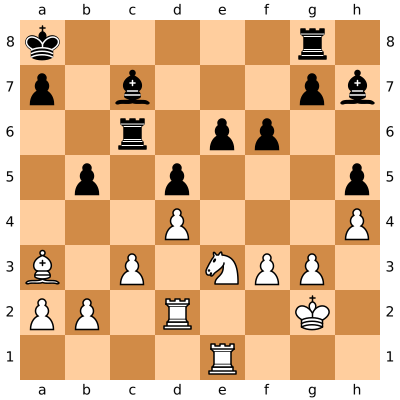

'to'

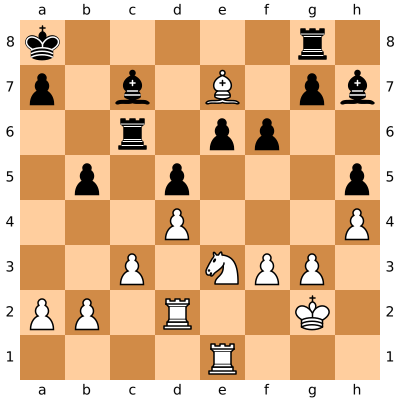

' Bishop to e7 <End>'

In [63]:
testCaption(14)

In [27]:
out = []
for i in range(len(correct)):
    out.append([correct[i], words[i]])
    
out

[['on', 'on'],
 ['g7', 'g5'],
 ['Queen', 'Queen'],
 ['<End>', '<End>'],
 ['to', 'to'],
 ['<End>', '<End>'],
 ['Pawn', 'Pawn'],
 ['King', 'King'],
 ['to', 'takes'],
 ['file', 'file'],
 ['to', 'to'],
 ['King', 'King'],
 ['<End>', '<End>'],
 ['Pawn', 'Pawn'],
 ['Bishop', 'Bishop'],
 ['Rook', 'Rook'],
 ['to', 'to'],
 ['file', 'file'],
 ['g6', 'g6'],
 ['King', 'Bishop'],
 ['g4', 'b3'],
 ['d4', 'd4'],
 ['<End>', '<End>'],
 ['King', 'King'],
 ['to', 'to'],
 ['d7', 'g3'],
 ['to', 'to'],
 ['d', 'd'],
 ['<End>', '<End>'],
 ['<End>', '<End>'],
 ['file', 'file'],
 ['a5', 'a5'],
 ['d7', 'b7'],
 ['from', 'from'],
 ['Pawn', 'Pawn'],
 ['<End>', '<End>'],
 ['Pawn', 'Pawn'],
 ['<End>', '<End>'],
 ['<End>', '<End>'],
 ['g5', 'g5'],
 ['f6', 'f6'],
 ['<End>', '<End>'],
 ['d7', 'd7'],
 ['<End>', '<End>'],
 ['to', 'to'],
 ['<End>', '<End>'],
 ['Bishop', 'Bishop'],
 ['Knight', 'Knight'],
 ['to', 'to'],
 ['<End>', '<End>'],
 ['file', 'file'],
 ['to', 'to'],
 ['d5', 'd5'],
 ['takes', 'takes'],
 ['<End>', '<End>